# Notebook Ilustrating a Benchmark HH Neuron to be used with Model Fitting

In [1]:
from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt
%matplotlib inline
prefs.codegen.target = 'cython'  # weave is not multiprocess-safe!


## HH Example

In [2]:
area = 20000*umetre**2

In [3]:
# Generate a step-current input and an "experimental" voltage trace
dt = 0.01*ms
input_current = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA

In [4]:
N, n1 = np.array([input_current]).shape

In [5]:
params = {'gl': float(5e-5*siemens*cm**-2 * area),
          'g_na': float(100*msiemens*cm**-2 * area),
          'g_kd': float(30*msiemens*cm**-2 * area)}
print ('"correct" parameters:', params)

"correct" parameters: {'gl': 1e-08, 'g_na': 2e-05, 'g_kd': 6e-06}


In [6]:
input_current.shape

(1497,)

In [7]:
# Parameters
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV
# gl = 5e-5*siemens*cm**-2 * area
# g_kd = 30*msiemens*cm**-2 * area

defaultclock.dt = dt
I = TimedArray(input_current, dt=dt)

In [29]:
# The model
eqsHH = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I(t))/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [9]:
G = NeuronGroup(1, eqsHH, method='exponential_euler')
G.v = El
G.set_states(params, units=False)
mon = StateMonitor(G, 'v', record=0)
run(20*ms)

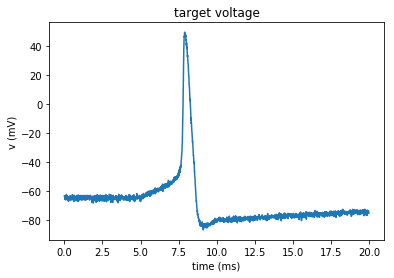

In [10]:
voltage = mon.v[0]/mV

voltage += np.random.randn(len(voltage))

plot(np.arange(len(voltage))*dt/ms, voltage); 
title('target voltage'); xlabel('time (ms)'); ylabel('v (mV)');

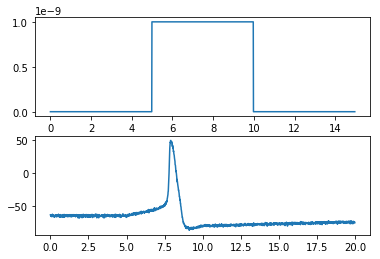

In [11]:
fig, ax = plt.subplots(2,1)
ax[0].plot(np.arange(len(I.values))*dt/ms, I.values);
ax[1].plot(np.arange(len(voltage))*dt/ms, voltage); 

In [12]:
inp_trace = np.array([input_current])
n0, n1 = inp_trace.shape
inp_trace.shape

(1, 1497)

In [13]:
out_trace = np.array([voltage[:n1]])
out_trace.shape

(1, 1497)

## brian2tools version 

In [14]:
eqs = Equations(
'''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''',
Cm = 1*ufarad*cm**-2 * area,El = -65*mV,EK = -90*mV,ENa = 50*mV,VT = -63*mV)

In [15]:
# params = {'gl': float(5e-5*siemens*cm**-2 * area),
#           'g_na': float(100*msiemens*cm**-2 * area),
#           'g_kd': float(30*msiemens*cm**-2 * area)}

In [16]:
gl = [1e-5, 1e-6]*siemens*cm**-2 * area,
g_na = [1, 200]*msiemens*cm**-2 * area,
g_kd = [1, 100]*msiemens*cm**-2 * area,

In [17]:
# Parameters
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV


In [18]:
params, fits, error = fit_traces(model = eqs, input_var = 'I', output_var = 'v',\
        input = inp_trace * nA, output = out_trace*mV, dt = dt,
        gl = [1e-5*siemens*cm**-2 * area, 1e-6*siemens*cm**-2 * area],
        g_na = [1*msiemens*cm**-2 * area, 200*msiemens*cm**-2 * area],
        g_kd = [1*msiemens*cm**-2 * area, 100*msiemens*cm**-2 * area],
        tol = 1e-6, popsize=10)

INFO       No numerical integration method specified, using method 'exponential_euler' (took 0.30s, trying other methods took 0.11s). [brian2.stateupdaters.base.method_choice]


input [[0. 0. 0. ... 0. 0. 0.]] A
differential_evolution step 1: f(x)= 0.00474859
differential_evolution step 2: f(x)= 0.00474859
differential_evolution step 3: f(x)= 0.00474859
differential_evolution step 4: f(x)= 0.00474859
differential_evolution step 5: f(x)= 0.00474859
differential_evolution step 6: f(x)= 0.00474859
differential_evolution step 7: f(x)= 0.00474859
differential_evolution step 8: f(x)= 0.00474859
differential_evolution step 9: f(x)= 0.00474859
differential_evolution step 10: f(x)= 0.00474859
differential_evolution step 11: f(x)= 0.00474859
differential_evolution step 12: f(x)= 0.00474859
differential_evolution step 13: f(x)= 0.00474859
differential_evolution step 14: f(x)= 0.00474859
differential_evolution step 15: f(x)= 0.00474859
differential_evolution step 16: f(x)= 0.00474859
differential_evolution step 17: f(x)= 0.00474859
differential_evolution step 18: f(x)= 0.00474859


In [19]:
params

{'g_kd': 7.1428041293014e-06,
 'g_na': 8.673650725169475e-06,
 'gl': 1.9996741061416924e-09}

In [20]:
fits

array([[0., 0., 0., ..., 0., 0., 0.]]) * volt

In [21]:
error

68.90999495 * mvolt

In [26]:
params_origin = {'gl': float(5e-5*siemens*cm**-2 * area),
          'g_na': float(100*msiemens*cm**-2 * area),
          'g_kd': float(30*msiemens*cm**-2 * area)}

params_origin

{'gl': 1e-08, 'g_na': 2e-05, 'g_kd': 6e-06}

In [25]:
params_origin['gl'] - params['gl']

8.000325893858308e-09

In [30]:
G = NeuronGroup(1, eqsHH, method='exponential_euler')
G.v = El
G.set_states(params, units=False)
mon = StateMonitor(G, 'v', record=0)
run(20*ms)

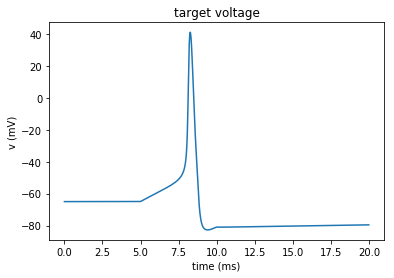

In [32]:
voltage = mon.v[0]/mV


plot(np.arange(len(voltage))*dt/ms, voltage); 
title('target voltage'); xlabel('time (ms)'); ylabel('v (mV)');

In [35]:
start_scope()

In [36]:
G1 = NeuronGroup(1, eqsHH, method='exponential_euler')
G1.v = El
G1.set_states(params_origin, units=False)
mon1 = StateMonitor(G1, 'v', record=0)
run(20*ms)

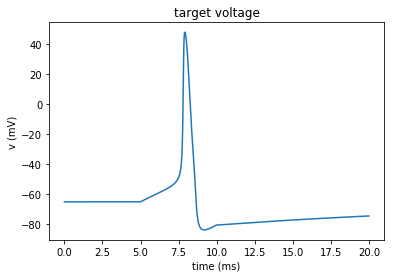

In [37]:
voltage1 = mon1.v[0]/mV

plot(np.arange(len(voltage1))*dt/ms, voltage1); 
title('target voltage'); xlabel('time (ms)'); ylabel('v (mV)');

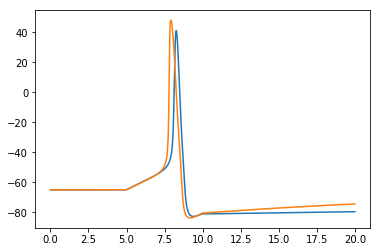

In [38]:
plot(np.arange(len(voltage))*dt/ms, voltage); 
plot(np.arange(len(voltage1))*dt/ms, voltage1); 
